In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/project/

/content/drive/MyDrive/project


## Import thư viện

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import re
import torch
import string
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from datasets import load_dataset

## Biến toàn cục

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


## Tải dữ liệu

In [31]:
dataset = load_dataset('glue', 'sst2')


In [32]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


## Xử lý dữ liệu

### Xử lý

In [33]:
df = dataset['train'].to_pandas()
df_test = dataset['validation'].to_pandas()
print(df.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  67349 non-null  object
 1   label     67349 non-null  int64 
 2   idx       67349 non-null  int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  872 non-null    object
 1   label     872 non-null    int64 
 2   idx       872 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 17.2+ KB
None


In [34]:
df.rename(columns={"sentence": "comment", "label": "sentiment"}, inplace=True)
df.drop('idx', axis=1, inplace=True)
df_test.rename(columns={"sentence": "comment", "label": "sentiment"}, inplace=True)
df_test.drop('idx', axis=1, inplace=True)

In [35]:
df.head()

,comment,sentiment
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [37]:
df_test.head()

,comment,sentiment
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0


### Phân tích

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    67349 non-null  object
 1   sentiment  67349 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [39]:
df.describe()

,sentiment
count,67349.000000
mean,0.557826
std,0.496649
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [40]:
df['sentiment'].value_counts()

,count
sentiment,
1,37569
0,29780


In [41]:
df['word_count'] = df['comment'].str.split().apply(len)

In [42]:
print("min: ", df['word_count'].min())
print("max: ", df['word_count'].max())
print("mean: ", df['word_count'].mean())
print("median: ", df['word_count'].median())
print("std: ", df['word_count'].std())

min:  1
max:  52
mean:  9.409553222765
median:  7.0
std:  8.073806407501392


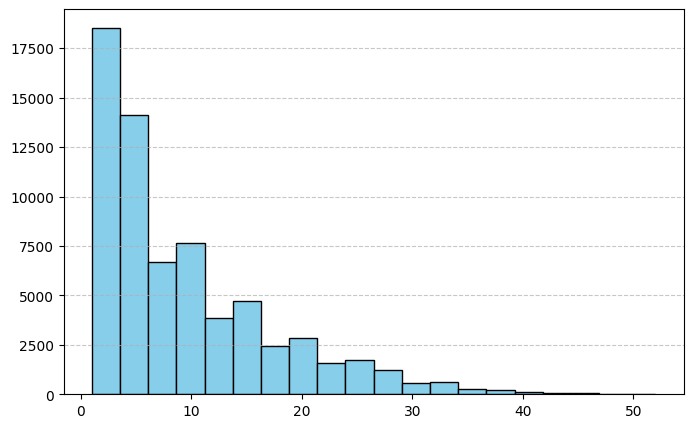

In [43]:
plt.figure(figsize=(8, 5))
plt.hist(df['word_count'], bins=20, color='skyblue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
# df.drop(columns=['word_count'], inplace=True)

### Tiền xử lý dữ liệu

In [44]:
# df = df[df['sentiment'].isin(["negative", "positive", "neutral"])]
# df['sentiment'].value_counts()

In [45]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

ps = PorterStemmer()
stop_word = set(stopwords.words("english"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_word])
    text = ' '.join(ps.stem(word) for word in word_tokenize(text))
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d", '', text)
    return text

df["comment"] = df["comment"].apply(preprocess_text)
df_test["comment"] = df_test["comment"].apply(preprocess_text)

df.head()


,comment,sentiment,word_count
0,hide new secret parent unit,0,7
1,contain wit labor gag,0,7
2,love charact commun someth rather beauti human...,1,12
3,remain utterli satisfi remain throughout,0,8
4,worst revengeofthenerd cliché filmmak could dredg,0,10


In [47]:
from collections import Counter
corpus = [word for text in df['comment'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common(2000)

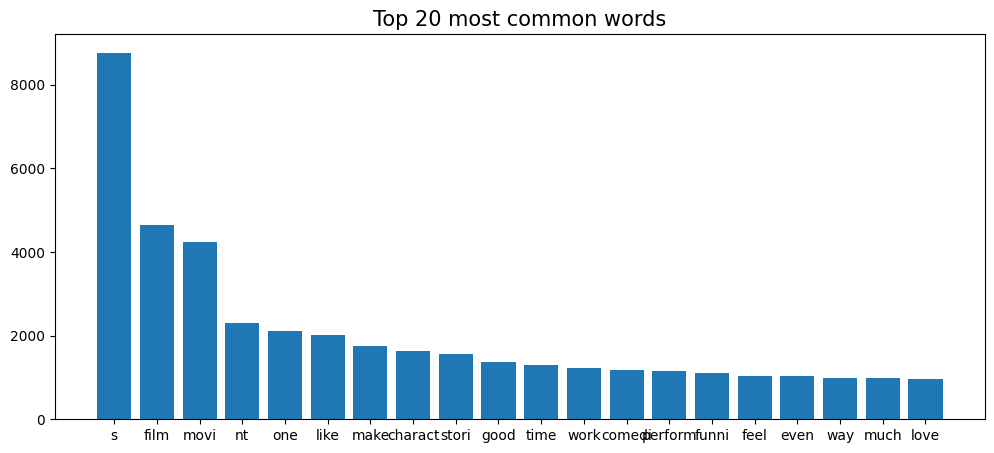

In [48]:
import matplotlib.pyplot as plt
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words', size=15)
plt.show()

In [49]:
# # Tách dữ liệu theo nhãn
# negative_samples = df[df['sentiment'] == 'negative']
# neutral_samples = df[df['sentiment'] == 'neutral']
# positive_samples = df[df['sentiment'] == 'positive']

# # Lấy mẫu lại (undersample) cho các nhãn lớn hơn
# negative_downsampled = resample(negative_samples,
#                                 replace=False,    # Không thay thế
#                                 n_samples=len(positive_samples),  # Bằng số lượng nhỏ nhất
#                                 random_state=42)

# neutral_downsampled = resample(neutral_samples,
#                                replace=False,
#                                n_samples=len(positive_samples),
#                                random_state=42)

# # Kết hợp lại
# df = pd.concat([negative_downsampled, neutral_downsampled, positive_samples])

In [50]:
df['sentiment'].value_counts()

,count
sentiment,
1,37569
0,29780


In [51]:
print("min: ", df['word_count'].min())
print("max: ", df['word_count'].max())
print("mean: ", df['word_count'].mean())
print("median: ", df['word_count'].median())
print("std: ", df['word_count'].std())

min:  1
max:  52
mean:  9.409553222765
median:  7.0
std:  8.073806407501392


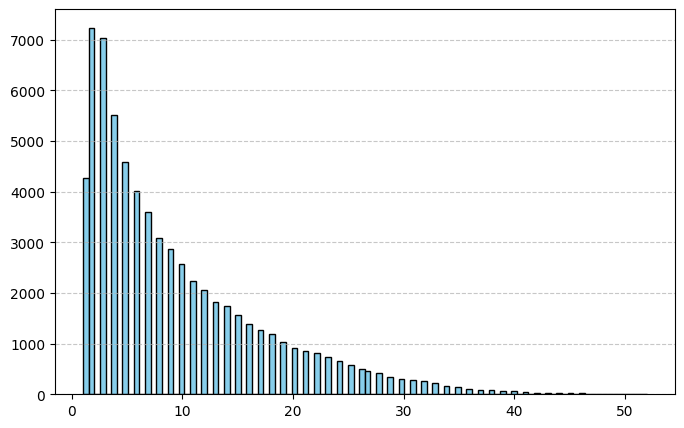

In [52]:
plt.figure(figsize=(8, 5))
plt.hist(df['word_count'], bins=100, color='skyblue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [53]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in df['comment']:
    r = [vocab_to_int[word] for word in text.split() if word in vocab_to_int]
    reviews_int.append(r)

reviews_int_test = []
for text in df_test['comment']:
    r = [vocab_to_int[word] for word in text.split() if word in vocab_to_int]
    reviews_int_test.append(r)

print(reviews_int[0])
print(reviews_int_test[0])
print(vocab_to_int)
print(len(reviews_int_test))

[33, 965, 559]
[1, 78, 87, 380, 591]
{'s': 1, 'film': 2, 'movi': 3, 'nt': 4, 'one': 5, 'like': 6, 'make': 7, 'charact': 8, 'stori': 9, 'good': 10, 'time': 11, 'work': 12, 'comedi': 13, 'perform': 14, 'funni': 15, 'feel': 16, 'even': 17, 'way': 18, 'much': 19, 'love': 20, 'bad': 21, 'littl': 22, 'look': 23, 'entertain': 24, 'best': 25, 'life': 26, 'enough': 27, 'watch': 28, 'get': 29, 'humor': 30, 'act': 31, 'see': 32, 'new': 33, 'come': 34, 'interest': 35, 'us': 36, 'plot': 37, 'take': 38, 'audienc': 39, 'never': 40, 'someth': 41, 'seem': 42, 'director': 43, 'year': 44, 'action': 45, 'great': 46, 'well': 47, 'end': 48, 'emot': 49, 'enjoy': 50, 'would': 51, 'cast': 52, 'made': 53, 'beauti': 54, 'mani': 55, 'realli': 56, 'drama': 57, 'filmmak': 58, 'go': 59, 'thing': 60, 'sens': 61, 'give': 62, 'could': 63, 'visual': 64, 'minut': 65, 'better': 66, 'peopl': 67, 'fun': 68, 'actor': 69, 'direct': 70, 'everi': 71, 'two': 72, 'human': 73, 'without': 74, 'noth': 75, 'power': 76, 'intellig': 77

In [54]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(review_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return features

In [55]:
import numpy as np
max_token_len = 30
features = Padding(reviews_int, max_token_len)
features_test = Padding(reviews_int_test, max_token_len)
print(features[0, :])
print(len(features))
print(len(features_test))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  33 965 559]
67349
872


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, df['sentiment'].to_numpy(),
                                                        test_size=0.2, random_state=42,
                                                        stratify=df['sentiment'])
X_test = features_test
y_test = df_test['sentiment'].to_numpy()

In [57]:
print(X_train[:5])  # Xem 5 hàng đầu tiên của X_train
print(y_train[:5])  # Xem 5 giá trị đầu tiên của y_train


[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    9   48  185    4  611
   217    8]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 1280]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   63  467  118  439  350 1192   76  283   99 1372
  1371 1434]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
   167  599]]
[1 0 0 1 0]


In [58]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Chuyển đổi y_train, y_test, y_valid thành số
# ['negative', 'neutral', 'positive'] -> [0, 1, 2]
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

In [113]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# dataloaders
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

## Model

### Helper

In [93]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    correct = preds.eq(labels.view_as(preds)).sum()
    acc = correct.float() / preds.shape[0]
    return acc


def calculate_accuracy(model, test_loader, device):
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (không tính gradient)

    correct = 0
    total = 0

    with torch.no_grad():  # Tắt tính toán gradient để giảm bộ nhớ và tính toán
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Đưa dữ liệu vào đúng thiết bị

            # Khởi tạo trạng thái ẩn
            hidden = model.init_hidden(inputs.size(0))
            hidden = tuple([each.data for each in hidden])  # Đảm bảo trạng thái ẩn là tensor

            # Dự đoán đầu ra từ mô hình
            outputs, hidden = model(inputs, hidden)  # Truyền hidden vào mô hình

            # Tính độ chính xác cho batch
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # So sánh dự đoán và nhãn thực tế

    accuracy = correct / total * 100  # Tính độ chính xác (%) của mô hình
    return accuracy


#### Pretrain Embedding

##### GoogleNews-vectors-negative300-SLIM

In [94]:
from gensim.models import KeyedVectors

path_to_google_news = "pre-trained/GoogleNews-vectors-negative300-SLIM.bin"

google_news_vectors = KeyedVectors.load_word2vec_format(path_to_google_news, binary=True)

In [95]:
import numpy as np

embedding_dim = 300  # GoogleNews vector size
vocab_size = len(vocab_to_int) + 1

# Khởi tạo ma trận embedding với giá trị ngẫu nhiên
embedding_matrix = np.random.uniform(-0.01, 0.01, (vocab_size, embedding_dim))

# Lấy embedding cho các từ trong từ điển của bạn
for word, idx in vocab_to_int.items():
    if word in google_news_vectors.key_to_index:
        embedding_matrix[idx] = google_news_vectors[word]

# Chuyển ma trận embedding thành tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

### LSTM

In [96]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)
        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [97]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 2  # 0, 1
embedding_dim = 64
hidden_dim = 256
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.4)
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


In [98]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 30
lr = 0.001
clip = 5  # gradient clipping

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/LSTM/weight_{epoch}.pth")

Epoch: 1/30... Train Loss: 0.566802... Val Loss: 0.507082... Train Acc: 72.29%... Val Acc: 79.41%
Epoch: 2/30... Train Loss: 0.482232... Val Loss: 0.476210... Train Acc: 82.08%... Val Acc: 82.77%
Epoch: 3/30... Train Loss: 0.457333... Val Loss: 0.464463... Train Acc: 84.78%... Val Acc: 83.97%
Epoch: 4/30... Train Loss: 0.444861... Val Loss: 0.460817... Train Acc: 86.11%... Val Acc: 84.46%
Epoch: 5/30... Train Loss: 0.434667... Val Loss: 0.453946... Train Acc: 87.20%... Val Acc: 85.25%
Epoch: 6/30... Train Loss: 0.428682... Val Loss: 0.447762... Train Acc: 87.79%... Val Acc: 85.83%
Epoch: 7/30... Train Loss: 0.424314... Val Loss: 0.450001... Train Acc: 88.32%... Val Acc: 85.61%
Epoch: 8/30... Train Loss: 0.420203... Val Loss: 0.443814... Train Acc: 88.70%... Val Acc: 86.29%
Epoch: 9/30... Train Loss: 0.416495... Val Loss: 0.445297... Train Acc: 89.09%... Val Acc: 86.07%
Epoch: 10/30... Train Loss: 0.415007... Val Loss: 0.442831... Train Acc: 89.19%... Val Acc: 86.36%
Epoch: 11/30... Tra

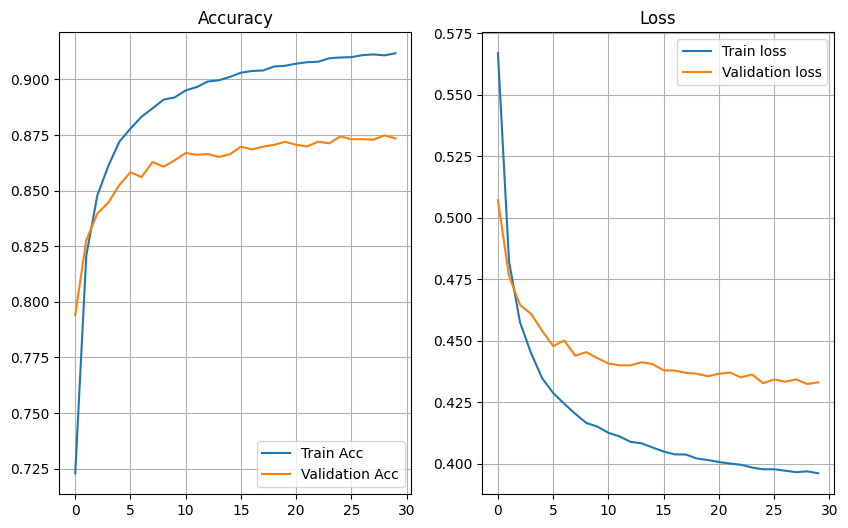

In [101]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [102]:
# model.load_state_dict(torch.load('weights/LSTM/weight_{epoch}.pth'))

In [103]:
calculate_accuracy(model, test_loader, device)

75.45871559633028

In [104]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i hate you")

0

### LSTM + Pre-trained Embedding

In [105]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)

        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [106]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 300
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.3)
model.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)  # freeze=True để giữ nguyên trọng số
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [107]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 50
lr = 0.001
clip = 5  # gradient clipping

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/LSTM_Pre-trained/weight_{epoch}.pth")

Epoch: 1/50... Train Loss: 0.856143... Val Loss: 0.808613... Train Acc: 67.12%... Val Acc: 72.55%
Epoch: 2/50... Train Loss: 0.920260... Val Loss: 0.816975... Train Acc: 62.01%... Val Acc: 71.62%
Epoch: 3/50... Train Loss: 0.792785... Val Loss: 0.789168... Train Acc: 74.60%... Val Acc: 74.87%
Epoch: 4/50... Train Loss: 0.781182... Val Loss: 0.781490... Train Acc: 75.97%... Val Acc: 75.78%
Epoch: 5/50... Train Loss: 0.770719... Val Loss: 0.772218... Train Acc: 77.07%... Val Acc: 76.90%
Epoch: 6/50... Train Loss: 0.760224... Val Loss: 0.768794... Train Acc: 78.23%... Val Acc: 77.32%
Epoch: 7/50... Train Loss: 0.752794... Val Loss: 0.760055... Train Acc: 79.11%... Val Acc: 78.38%
Epoch: 8/50... Train Loss: 0.744704... Val Loss: 0.760228... Train Acc: 79.94%... Val Acc: 78.50%
Epoch: 9/50... Train Loss: 0.738043... Val Loss: 0.753133... Train Acc: 80.58%... Val Acc: 79.23%
Epoch: 10/50... Train Loss: 0.733780... Val Loss: 0.750273... Train Acc: 81.20%... Val Acc: 79.49%
Epoch: 11/50... Tra

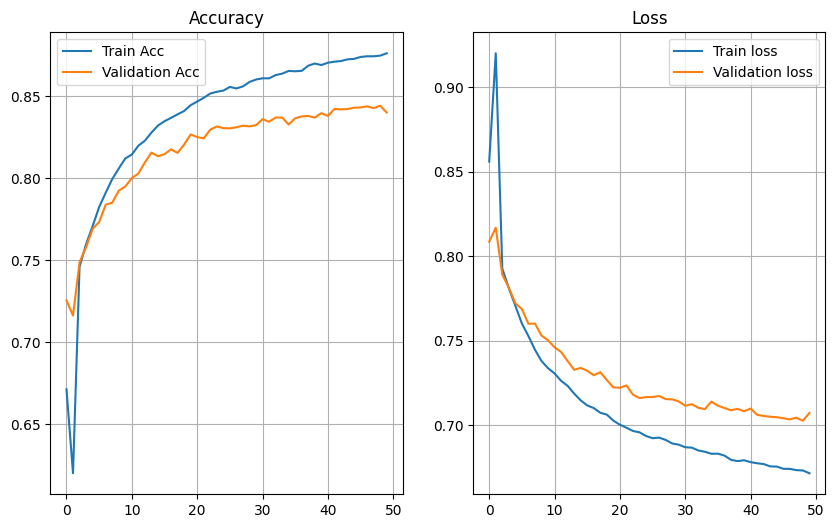

In [109]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [86]:
model.load_state_dict(torch.load('weights/LSTM_Pre-trained/weight_20.pth'))

In [111]:
calculate_accuracy(model, test_loader, device)

70.75688073394495

In [112]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

1

### Bidirectional LSTM

In [127]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)
        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())
        return hidden

In [128]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 64
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [129]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []
# Hyperparameters
epochs = 30
lr = 0.001
clip = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/biLSTM/weight_{epoch}.pth")

Epoch: 1/30... Train Loss: 0.852511... Val Loss: 0.780588... Train Acc: 68.08%... Val Acc: 76.28%
Epoch: 2/30... Train Loss: 0.744016... Val Loss: 0.738286... Train Acc: 80.17%... Val Acc: 80.84%
Epoch: 3/30... Train Loss: 0.719430... Val Loss: 0.722807... Train Acc: 82.69%... Val Acc: 82.38%
Epoch: 4/30... Train Loss: 0.705926... Val Loss: 0.717837... Train Acc: 84.12%... Val Acc: 82.82%
Epoch: 5/30... Train Loss: 0.698920... Val Loss: 0.713583... Train Acc: 84.83%... Val Acc: 83.25%
Epoch: 6/30... Train Loss: 0.692029... Val Loss: 0.713535... Train Acc: 85.57%... Val Acc: 83.35%
Epoch: 7/30... Train Loss: 0.688970... Val Loss: 0.708140... Train Acc: 85.88%... Val Acc: 83.92%
Epoch: 8/30... Train Loss: 0.685146... Val Loss: 0.705538... Train Acc: 86.29%... Val Acc: 84.17%
Epoch: 9/30... Train Loss: 0.682102... Val Loss: 0.705522... Train Acc: 86.62%... Val Acc: 84.18%
Epoch: 10/30... Train Loss: 0.680143... Val Loss: 0.704596... Train Acc: 86.74%... Val Acc: 84.24%
Epoch: 11/30... Tra

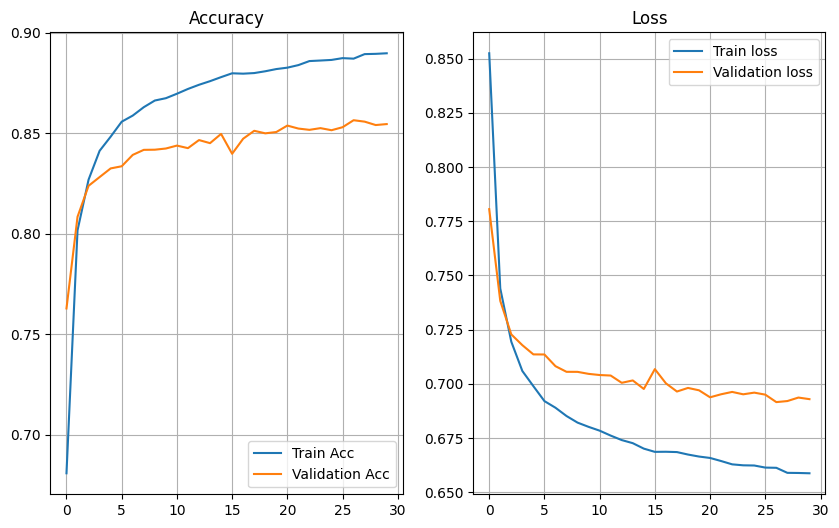

In [130]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [131]:
# model.load_state_dict(torch.load('weights/biLSTM/weight_20.pth'))

In [132]:
calculate_accuracy(model, test_loader, device)

75.3440366972477

In [133]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

1

### Bidirectional LSTM + Attension

In [145]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, lstm_out):
        attention_scores = torch.matmul(lstm_out, self.attention_weights)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(attention_weights.unsqueeze(2) * lstm_out, dim=1)
        return weighted_sum

In [146]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True, bidirectional=True)

        self.attention = AttentionLayer(hidden_dim * 2)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.attention(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)

        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())
        return hidden

In [147]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 64
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): AttentionLayer()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [148]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 30
lr = 0.001
clip = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/biLSTM_Attension/weight_{epoch}.pth")


Epoch: 1/30... Train Loss: 0.905814... Val Loss: 0.801634... Train Acc: 61.38%... Val Acc: 74.29%
Epoch: 2/30... Train Loss: 0.764223... Val Loss: 0.740723... Train Acc: 77.84%... Val Acc: 80.43%
Epoch: 3/30... Train Loss: 0.732081... Val Loss: 0.787066... Train Acc: 81.35%... Val Acc: 76.45%
Epoch: 4/30... Train Loss: 0.723806... Val Loss: 0.722375... Train Acc: 82.23%... Val Acc: 82.38%
Epoch: 5/30... Train Loss: 0.715998... Val Loss: 0.725156... Train Acc: 82.95%... Val Acc: 82.13%
Epoch: 6/30... Train Loss: 0.712640... Val Loss: 0.716950... Train Acc: 83.39%... Val Acc: 82.94%
Epoch: 7/30... Train Loss: 0.709589... Val Loss: 0.716548... Train Acc: 83.65%... Val Acc: 83.14%
Epoch: 8/30... Train Loss: 0.707307... Val Loss: 0.718322... Train Acc: 83.89%... Val Acc: 82.79%
Epoch: 9/30... Train Loss: 0.707397... Val Loss: 0.726979... Train Acc: 83.91%... Val Acc: 81.18%
Epoch: 10/30... Train Loss: 0.704073... Val Loss: 0.718287... Train Acc: 84.30%... Val Acc: 82.91%
Epoch: 11/30... Tra

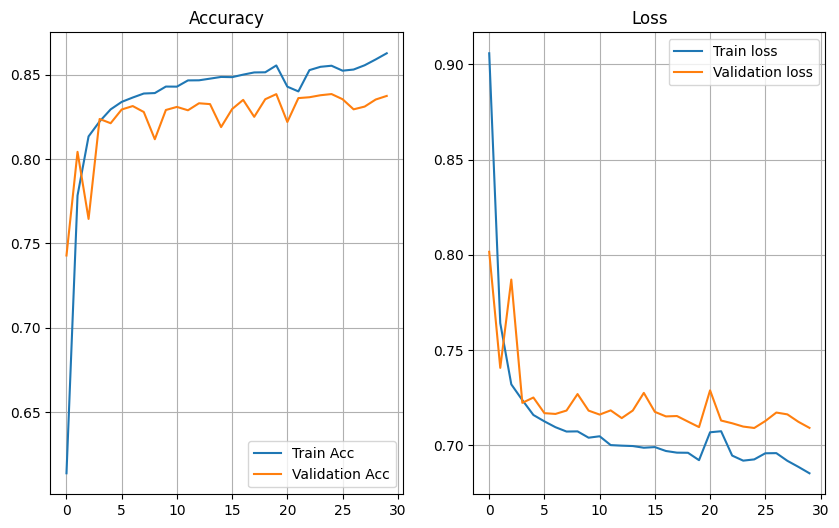

In [150]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [151]:
# model.load_state_dict(torch.load('weights/biLSTM_Attension/weight_{epoch}.pth'))

In [152]:
calculate_accuracy(model, test_loader, device)

75.0

In [153]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

1

### Bidirectional LSTM + Attension + Pre-trained Embedding

In [154]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, lstm_out):
        attention_scores = torch.matmul(lstm_out, self.attention_weights)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(attention_weights.unsqueeze(2) * lstm_out, dim=1)
        return weighted_sum

In [155]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True, bidirectional=True)

        self.attention = AttentionLayer(hidden_dim * 2)

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()

        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.attention(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        soft_out = self.softmax(out)

        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]

        return soft_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers * 2, batch_size, self.hidden_dim).zero_())
        return hidden

In [156]:
# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3
embedding_dim = 300
hidden_dim = 128
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5)
model.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)  # freeze=True để giữ nguyên trọng số
print(model)

SentimentLSTM(
  (embedding): Embedding(2001, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): AttentionLayer()
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [157]:
set_seed(42)
model.to(device)

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Hyperparameters
epochs = 50
lr = 0.001
clip = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = np.mean(train_accs)
    epoch_val_acc = np.mean(val_accs)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {epoch_train_loss:.6f}... "
          f"Val Loss: {epoch_val_loss:.6f}... "
          f"Train Acc: {epoch_train_acc * 100:.2f}%... "
          f"Val Acc: {epoch_val_acc * 100:.2f}%")

    torch.save(model.state_dict(), f"weights/biLSTM_Attension_Pre-trained/weight_{epoch}.pth")


Epoch: 1/50... Train Loss: 0.882454... Val Loss: 0.831032... Train Acc: 64.85%... Val Acc: 70.31%
Epoch: 2/50... Train Loss: 0.835780... Val Loss: 0.846170... Train Acc: 69.95%... Val Acc: 70.35%
Epoch: 3/50... Train Loss: 0.812670... Val Loss: 0.801919... Train Acc: 72.15%... Val Acc: 73.28%
Epoch: 4/50... Train Loss: 0.797518... Val Loss: 0.793833... Train Acc: 73.99%... Val Acc: 74.39%
Epoch: 5/50... Train Loss: 0.787670... Val Loss: 0.794137... Train Acc: 75.07%... Val Acc: 74.13%
Epoch: 6/50... Train Loss: 0.783838... Val Loss: 0.783905... Train Acc: 75.55%... Val Acc: 75.44%
Epoch: 7/50... Train Loss: 0.784573... Val Loss: 0.790856... Train Acc: 75.47%... Val Acc: 75.07%
Epoch: 8/50... Train Loss: 0.800014... Val Loss: 0.790199... Train Acc: 74.24%... Val Acc: 75.08%
Epoch: 9/50... Train Loss: 0.776393... Val Loss: 0.776038... Train Acc: 76.51%... Val Acc: 76.41%
Epoch: 10/50... Train Loss: 0.767191... Val Loss: 0.774508... Train Acc: 77.49%... Val Acc: 76.51%
Epoch: 11/50... Tra

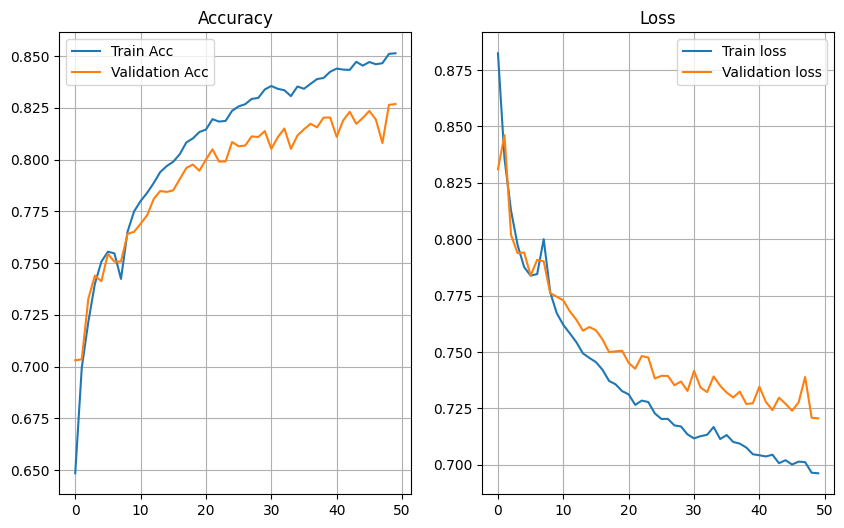

In [158]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
# model.load_state_dict(torch.load('weights/biLSTM_Attension_Pre-trained/weight_{epoch}.pth'))

In [159]:
calculate_accuracy(model, test_loader, device)

70.18348623853211

In [160]:
def predict_text(text):
        text = preprocess_text(text)
        r = [[vocab_to_int[word] for word in text.split() if word in vocab_to_int]]
        pad = Padding(r,30)
        inputs = torch.tensor(pad).to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return torch.argmax(output, dim=1).item()

predict_text("i love you")

1